<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Process-CCSs" data-toc-modified-id="Process-CCSs-1">Process CCSs</a></span><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1.1">Setup</a></span></li><li><span><a href="#CCS-stats-for-PacBio-runs" data-toc-modified-id="CCS-stats-for-PacBio-runs-1.2">CCS stats for PacBio runs</a></span></li><li><span><a href="#PacBio-amplicon" data-toc-modified-id="PacBio-amplicon-1.3">PacBio amplicon</a></span></li><li><span><a href="#Align-CCSs-to-amplicon" data-toc-modified-id="Align-CCSs-to-amplicon-1.4">Align CCSs to amplicon</a></span></li><li><span><a href="#Examine-strand-exchange" data-toc-modified-id="Examine-strand-exchange-1.5">Examine strand exchange</a></span></li><li><span><a href="#Get-and-write-valid-CCSs" data-toc-modified-id="Get-and-write-valid-CCSs-1.6">Get and write valid CCSs</a></span></li></ul></li></ul></div>

# Process CCSs
This Python Jupyter notebook processes the PacBio circular consensus sequences (CCSs) to extract barcodes and call mutations in the gene.

## Setup

Import Python modules

Plotting is done with [plotnine](https://plotnine.readthedocs.io/en/stable/), which uses ggplot2-like syntax.

The analysis uses the Bloom lab's [alignparse](https://jbloomlab.github.io/alignparse) and [dms_variants](https://jbloomlab.github.io/dms_variants) packages.

In [1]:
import collections
import math
import os
import re
import time
import warnings

import alignparse
import alignparse.ccs
from alignparse.constants import CBPALETTE
import alignparse.minimap2
import alignparse.targets

import dms_variants
import dms_variants.plotnine_themes
import dms_variants.utils

from IPython.display import display, HTML

import numpy

import pandas as pd

from plotnine import *

import yaml

Set [plotnine](https://plotnine.readthedocs.io/en/stable/) theme to the one defined in [dms_variants](https://jbloomlab.github.io/dms_variants):

In [2]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

Versions of key software:

In [3]:
print(f"Using alignparse version {alignparse.__version__}")
print(f"Using dms_variants version {dms_variants.__version__}")

Using alignparse version 0.1.0
Using dms_variants version 0.4.6


Ignore warnings that clutter output:

In [4]:
warnings.simplefilter('ignore')

Read the configuration file:

In [5]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Make output directory for figures:

In [6]:
os.makedirs(config['figs_dir'], exist_ok=True)
os.makedirs(config['process_ccs_dir'], exist_ok=True)

## CCS stats for PacBio runs
Read data frame with information on PacBio runs:

In [7]:
pacbio_runs = (
    pd.read_csv(config['pacbio_runs'], dtype=str)
    .drop(columns=['subreads'])
    .assign(name=lambda x: x['library'] + '_' + x['run'],
            fastq=lambda x: config['ccs_dir'] + '/' + x['name'] + '_ccs.fastq.gz'
            )
    )

# we only have report files on the Hutch server, not for SRA download
if config['seqdata_source'] == 'HutchServer':
    pacbio_runs = (
        pacbio_runs
        .assign(report=lambda x: config['ccs_dir'] + '/' + x['name'] + '_report.txt')
        )
    report_col = 'report'
elif config['seqdata_source'] == 'SRA':
    report_col = None
else:
    raise ValueError(f"invalid `seqdata_source` {config['seqdata_source']}")

display(HTML(pacbio_runs.to_html(index=False)))

library,run,name,fastq,report
libA2,190919,libA2_190919,results/ccs/libA2_190919_ccs.fastq.gz,results/ccs/libA2_190919_report.txt
libA2,191017,libA2_191017,results/ccs/libA2_191017_ccs.fastq.gz,results/ccs/libA2_191017_report.txt
libB2,191125_A,libB2_191125_A,results/ccs/libB2_191125_A_ccs.fastq.gz,results/ccs/libB2_191125_A_report.txt
libB2,191125_B,libB2_191125_B,results/ccs/libB2_191125_B_ccs.fastq.gz,results/ccs/libB2_191125_B_report.txt


Create an object that summarizes the `ccs` runs:

In [8]:
ccs_summaries = alignparse.ccs.Summaries(pacbio_runs,
                                         report_col=report_col,
                                         ncpus=config['max_cpus'],
                                         )

If available, plot statistics on the number of ZMWs for each run:

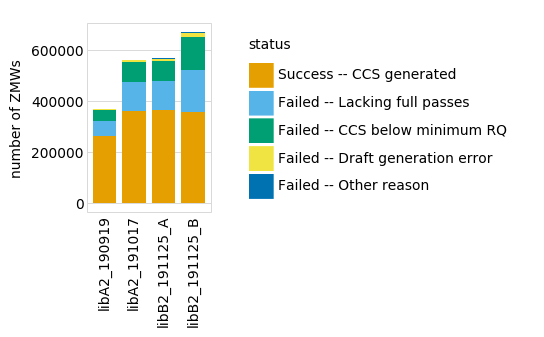

In [9]:
if ccs_summaries.has_zmw_stats():
    p = ccs_summaries.plot_zmw_stats()
    p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
    _ = p.draw()
else:
    print('No ZMW stats available.')

Plot statistics on generated CCSs: their length, number of subread passes, and accuracy (as reported by the `ccs` program):

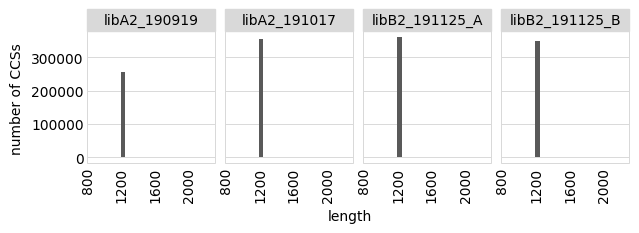

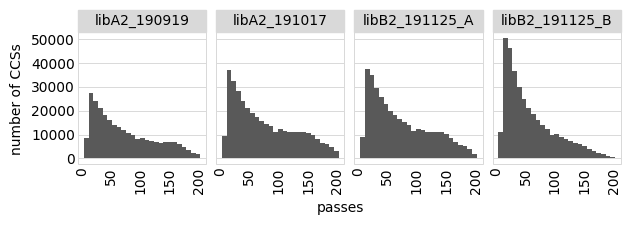

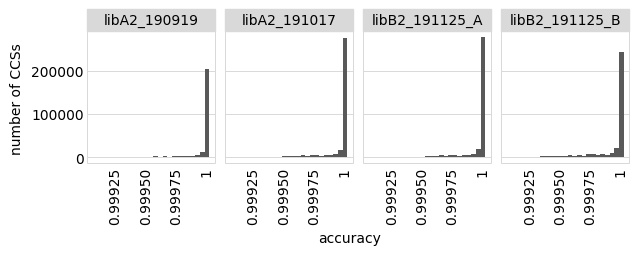

In [10]:
for variable in ['length', 'passes', 'accuracy']:
    if ccs_summaries.has_stat(variable):
        p = ccs_summaries.plot_ccs_stats(variable, maxcol=7, bins=25)
        p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
        _ = p.draw()
    else:
        print(f"No {variable} statistics available.")

## PacBio amplicon
Get the amplicon sequenced by PacBio as the alignment target along with the specs on how to parse the features:

In [11]:
print(f"Reading amplicon from {config['amplicon']}")
print(f"Reading feature parse specs from {config['feature_parse_specs']}")

targets = alignparse.targets.Targets(
                seqsfile=config['amplicon'],
                feature_parse_specs=config['feature_parse_specs'])

Reading amplicon from data/PacBio_amplicon.gb
Reading feature parse specs from data/feature_parse_specs.yaml


Draw the target amplicon:

Saving plot to results/figures/amplicon.pdf


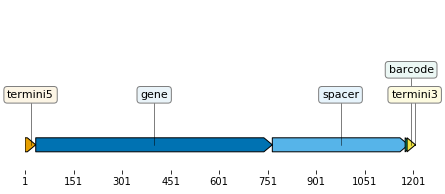

In [12]:
fig = targets.plot(ax_width=7)
_ = fig.gca().set_title(None)  # hide target title as just one target

plotfile = os.path.join(config['figs_dir'], 'amplicon.pdf')
print(f"Saving plot to {plotfile}")
fig.savefig(plotfile, bbox_inches='tight')

Write out the specs used to parse the features (these are the same specs provided as `feature_parse_specs` when initializing `targets`, but with defaults filled in):

In [13]:
print(targets.feature_parse_specs('yaml'))

NIH45-46_PacBio_amplicon:
  query_clip5: 4
  query_clip3: 4
  termini5:
    filter:
      clip5: 4
      mutation_nt_count: 1
      mutation_op_count: null
      clip3: 0
    return: []
  gene:
    filter:
      mutation_nt_count: 45
      mutation_op_count: null
      clip5: 0
      clip3: 0
    return:
    - mutations
    - accuracy
  spacer:
    filter:
      mutation_nt_count: 1
      mutation_op_count: null
      clip5: 0
      clip3: 0
    return: []
  barcode:
    filter:
      mutation_nt_count: 0
      mutation_op_count: null
      clip5: 0
      clip3: 0
    return:
    - sequence
    - accuracy
  termini3:
    filter:
      clip3: 4
      mutation_nt_count: 1
      mutation_op_count: null
      clip5: 0
    return: []



## Align CCSs to amplicon
We now align the CCSs to the amplicon and parse features from the resulting alignments using the specs above.

First, we initialize an `alignparse.minimap2.Mapper` to align the reads to SAM files:

In [14]:
mapper = alignparse.minimap2.Mapper(alignparse.minimap2.OPTIONS_CODON_DMS)

print(f"Using `minimap2` {mapper.version} with these options:\n" +
      ' '.join(mapper.options))

Using `minimap2` 2.17-r941 with these options:
-A2 -B4 -O12 -E2 --end-bonus=13 --secondary=no --cs


Next, we use `Targets.align_and_parse` to create the alignments and parse them:

In [15]:
readstats, aligned, filtered = targets.align_and_parse(
        df=pacbio_runs,
        mapper=mapper,
        outdir=config['process_ccs_dir'],
        name_col='run',
        group_cols=['name', 'library'],
        queryfile_col='fastq',
        overwrite=True,
        ncpus=config['max_cpus'],
        )

First, examine the read stats from the alignment / parsing.
Since we only have one target we remove the target name from the stats:

In [16]:
assert len(targets.targets) == 1, 'do not do this if multiple targets'

readstats = (
    readstats
    .assign(category=lambda x: x['category'].str.split().str[0],
            valid=lambda x: x['category'] == 'aligned')
    )

Now plot the read stats for all runs:

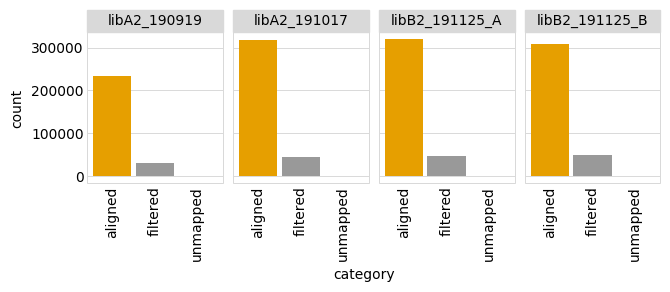

In [17]:
ncol = 7
p = (
    ggplot(readstats, aes('category', 'count', fill='valid')) +
    geom_bar(stat='identity') +
    facet_wrap('~ name', ncol=ncol) +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(1.85 * min(ncol, len(pacbio_runs)),
                       2 * math.ceil(len(pacbio_runs) / ncol)),
          panel_grid_major_x=element_blank(),
          legend_position='none',
          ) +
    scale_fill_manual(values=CBPALETTE)
    )
_ = p.draw()

And the read stats by library (combining all runs within a library):

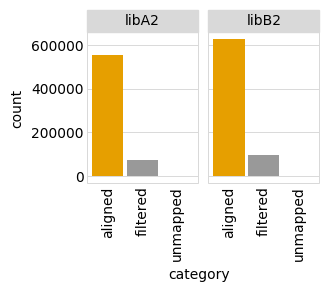

In [18]:
p = (
    ggplot(readstats
           .groupby(['library', 'category', 'valid'])
           .aggregate({'count': 'sum'})
           .reset_index(), 
           aes('category', 'count', fill='valid')) +
    geom_bar(stat='identity') +
    facet_wrap('~ library', nrow=1) +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(1.5 * pacbio_runs['library'].nunique(), 2),
          panel_grid_major_x=element_blank(),
          legend_position='none',
          ) +
    scale_fill_manual(values=CBPALETTE)
    )
_ = p.draw()

Now let's see **why** we filtered the reads.
First, we do some transformations on the `filtered` dict returned by `Targets.align_and_parse`.
We only care about the filtering for our one target, so just get the data frame for that target.
Then we count up the number of CCSs filtered for each reason, and group together "unusual" reasons that represent less than some fraction of all filtering:

In [19]:
assert len(targets.targets) == 1, 'do not do this if multiple targets'

other_cutoff = 0.02  # group as "other" reasons with <= this frac

filtered_df = (
    filtered[targets.target_names[0]]
    .groupby(['library', 'name', 'run', 'filter_reason'])
    .size()
    .rename('count')
    .reset_index()
    .assign(tot_reason_frac=lambda x: (x.groupby('filter_reason')['count']
                                       .transform('sum')) / x['count'].sum(),
            filter_reason=lambda x: numpy.where(x['tot_reason_frac'] > other_cutoff,
                                                x['filter_reason'],
                                                'other')
            )
    )

Now plot the filtering reason for all runs:

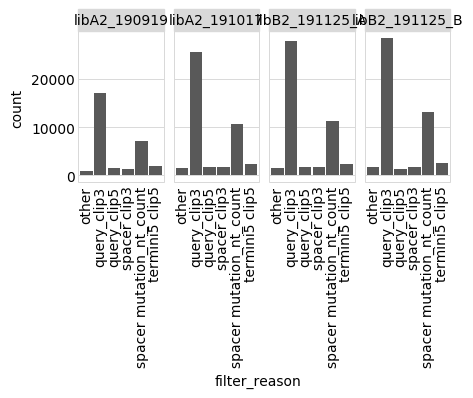

In [20]:
ncol = 7
nreasons = filtered_df['filter_reason'].nunique()

p = (
    ggplot(filtered_df, aes('filter_reason', 'count')) +
    geom_bar(stat='identity') +
    facet_wrap('~ name', ncol=ncol) +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(0.2 * nreasons * min(ncol, len(pacbio_runs)),
                       2 * math.ceil(len(pacbio_runs) / ncol)),
          panel_grid_major_x=element_blank(),
          )
    )
_ = p.draw()

Now make a similar plot to above, but combine all the runs for each library:

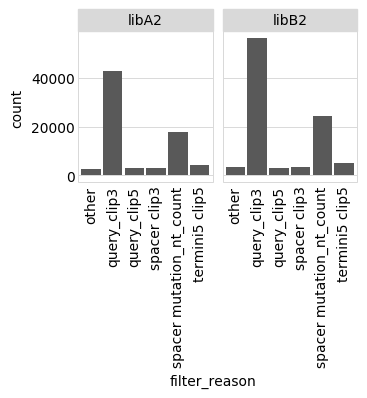

In [21]:
p = (
    ggplot(filtered_df
           .groupby(['library', 'filter_reason'])
           .aggregate({'count': 'sum'})
           .reset_index(),
           aes('filter_reason', 'count')) +
    geom_bar(stat='identity') +
    facet_wrap('~ library', nrow=1) +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(0.3 * nreasons * pacbio_runs['library'].nunique(), 2),
          panel_grid_major_x=element_blank(),
          )
    )
_ = p.draw()

Finally, we take the successfully parsed alignments.
We get them just for our single target.
We also drop the pieces of information we won't use going forward, and rename a few columns:

In [22]:
assert len(targets.targets) == 1, 'do not do this if multiple targets'

aligned_df = (
    aligned[targets.target_names[0]]
    .drop(columns=['query_clip5', 'query_clip3', 'run','name'])
    .rename(columns={'barcode_sequence': 'barcode'})
    )

print(f"First few lines of information on the parsed alignments:")
display(HTML(aligned_df.head().to_html(index=False)))

First few lines of information on the parsed alignments:


library,query_name,gene_mutations,gene_accuracy,barcode,barcode_accuracy
libA2,m54228_190921_105742/4194384/ccs,G131T T132C,0.99999,AATCGTACCGTAGATA,1.0
libA2,m54228_190921_105742/4194398/ccs,G492C,1.00000,ATAAGAGAAAAACCAT,1.0
libA2,m54228_190921_105742/4194401/ccs,C1G A2T G3C C58T T60C G582T G655C del685to685 T694G T695A T696G,1.00000,ATCGATAAAATATCAA,1.0
libA2,m54228_190921_105742/4194410/ccs,T557G T558G T634C,1.00000,GGCACGCCTCGATAGA,1.0
libA2,m54228_190921_105742/4194432/ccs,T13C C14T A15C T328A G604C G605T A606G T652G C653A,1.00000,GCGGTTTCAAATAGAG,1.0


## Write valid CCSs

Write the processed CCSs to a file:

In [23]:
aligned_df.to_csv(config['processed_ccs_file'], index=False)

print("Barcodes and mutations for valid processed CCSs "
      f"have been written to {config['processed_ccs_file']}.")

Barcodes and mutations for valid processed CCSs have been written to results/process_ccs/processed_ccs.csv.


In the next notebook, we analyze these processed CCSs to build the variants.